In [1]:
# --- Célula 1: Importações ---
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys

# --- ADICIONADO: Import do LightGBM ---
from lightgbm import LGBMClassifier
# ------------------------------------

# Ferramentas de Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Métricas de Avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# --- Célula 2: Carregamento dos Dados Mestres ---

# Carrega a tabela de modelagem COMPLETA (com todos os anos)
path_final_table = '../data/processed/modeling_table_final.parquet' 
df_completo = pd.read_parquet(path_final_table)

print(f"Tabela de modelagem mestra carregada com {df_completo.shape[0]} dias e {df_completo.shape[1]} colunas.")
print(f"Período total dos dados: de {df_completo.index.min().date()} a {df_completo.index.max().date()}.")

Tabela de modelagem mestra carregada com 5693 dias e 29 colunas.
Período total dos dados: de 2010-02-10 a 2025-09-11.


In [3]:
# --- Célula 3: Definição dos Grupos de Features ---

features_carga = ['programada', 'verificada', 'diferenca_verif_prog']
features_geracao = ['geracao_total_diaria_go', 'geracao_fotovoltaica_diaria', 'geracao_hidroelétrica_diaria', 'geracao_térmica_diaria']
features_rede = ['total_mwh_restrito_go', 'saldo_intercambio_seco', 'restricao_razao_rel', 'restricao_razao_cnf', 'restricao_razao_ene', 'restricao_razao_par', 'restricao_origem_loc', 'restricao_origem_sis']
features_hidrica = ['ear_percentual_seco', 'ena_percentual_mlt_seco']
features_adicionais = ['cmo_semanal_seco', 'disponibilidade_total_diaria_go', 'indicador_ccal_mensal']
features_clima = ['ghi', 'temp2m_c', 'precipitacao_mm']
features_avancadas = ['carga_media_7d', 'carga_std_7d', 'geracao_media_7d', 'ear_ontem', 'ear_diff_3d', 'margem_oferta_demanda', 'pressao_demanda_ear', 'precip_acumulada_14d', 'precip_acumulada_30d']
features_calendario = ['mes', 'dia_da_semana', 'dia_do_ano']

print("Grupos de features definidos com sucesso.")

Grupos de features definidos com sucesso.


In [4]:
# --- Célula 4: Painel de Controle do Experimento (LightGBM) ---
import sys

# Adiciona a pasta raiz ao path para encontrar o config.py
sys.path.append('..') 
from config import END_YEAR

# --- ESCOLHA O CENÁRIO PARA TESTAR ---
# Opções: 'pos_2022', 'pos_2020', 'pos_2017', 'pos_2015', 'pos_2013', 'pos_2010'
CENARIO_ESCOLHIDO = 'pos_2010' 
# -------------------------------------

# Define o período de análise e as features com base no cenário escolhido
if CENARIO_ESCOLHIDO == 'pos_2022':
    START_YEAR = 2022
    nome_cenario = "LGBM Pós-2022 (Features de Geração)"
    features_para_teste_nomes = (
        features_geracao + features_rede + features_hidrica +
        features_adicionais + features_clima + features_calendario +
        features_avancadas + ['programada'] 
    )
elif CENARIO_ESCOLHIDO == 'pos_2020':
    START_YEAR = 2020
    nome_cenario = "LGBM Pós-2020 (Histórico com Carga Prog.)"
    features_para_teste_nomes = (
        features_hidrica + features_adicionais + features_clima +
        features_calendario + features_avancadas + ['programada']
    )
elif CENARIO_ESCOLHIDO == 'pos_2017':
    START_YEAR = 2017
    nome_cenario = "LGBM Pós-2017 (Histórico Intermediário)"
    features_para_teste_nomes = (
        features_hidrica + features_adicionais + features_clima +
        features_calendario + features_avancadas
    )
elif CENARIO_ESCOLHIDO == 'pos_2015':
    START_YEAR = 2015
    nome_cenario = "LGBM Pós-2015 (Histórico com Disponibilidade)"
    features_para_teste_nomes = (
        features_hidrica + features_adicionais + features_clima +
        features_calendario + features_avancadas
    )
elif CENARIO_ESCOLHIDO == 'pos_2013':
    START_YEAR = 2013
    nome_cenario = "LGBM Pós-2013 (Histórico Extendido Básico)"
    features_para_teste_nomes = (
        features_hidrica + features_clima + features_calendario + 
        features_avancadas + ['cmo_semanal_seco', 'indicador_ccal_mensal']
    )
elif CENARIO_ESCOLHIDO == 'pos_2010':
    START_YEAR = 2010
    nome_cenario = "LGBM Pós-2010 (Máximo Histórico Básico)"
    features_para_teste_nomes = (
        features_hidrica + features_clima + features_calendario + 
        features_avancadas + ['cmo_semanal_seco', 'indicador_ccal_mensal']
    )
else:
    raise ValueError("Cenário escolhido é inválido.")

print(f"--- INICIANDO EXPERIMENTO COM O CENÁRIO: '{nome_cenario}' ---")
print(f"Período de análise: de {START_YEAR} a {END_YEAR}")

# --- FILTRAGEM E SELEÇÃO DE DADOS ---
# 1. Filtra a tabela mestra para o período do experimento
anos_de_interesse = range(START_YEAR, END_YEAR + 1)
df = df_completo[df_completo.index.year.isin(anos_de_interesse)].copy()
print(f"-> Tabela filtrada por data, resultando em {df.shape[0]} dias para modelagem.")

# 2. Seleciona apenas as colunas válidas para o cenário (e que existem no dataframe)
# Isso remove automaticamente features avançadas que dependem de colunas ausentes.
features_para_teste = [col for col in features_para_teste_nomes if col in df.columns]
X = df[features_para_teste]
y = df['nivel_risco']

print(f"Número de features selecionadas para este cenário: {len(X.columns)}")
print("\nAmostragem de classes no dataset deste cenário:")
print(y.value_counts())

--- INICIANDO EXPERIMENTO COM O CENÁRIO: 'LGBM Pós-2010 (Máximo Histórico Básico)' ---
Período de análise: de 2010 a 2025
-> Tabela filtrada por data, resultando em 5693 dias para modelagem.
Número de features selecionadas para este cenário: 15

Amostragem de classes no dataset deste cenário:
nivel_risco
baixo    5582
medio      84
alto       27
Name: count, dtype: int64


In [5]:
# --- Célula 5: Preparação dos Dados para Modelagem ---

mapeamento_risco = {'baixo': 0, 'medio': 1, 'alto': 2}
y_encoded = y.map(mapeamento_risco)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n--- Aplicando SMOTE nos dados de treino ---\n")
min_class_count = y_train.value_counts().min()
if min_class_count > 1:
    k_neighbors_smote = min(5, min_class_count - 1)
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
else:
    print("AVISO: A menor classe tem apenas 1 membro no treino. Pulando o SMOTE.")
    X_train_resampled, y_train_resampled = X_train_scaled, y_train

print("\nPreparação dos dados concluída.")


--- Aplicando SMOTE nos dados de treino ---


Preparação dos dados concluída.


In [6]:
# --- Célula 6 (Versão Corrigida): Busca de Hiperparâmetros com LightGBM ---

# Grade de parâmetros ajustada para LightGBM
param_grid = {
    'n_estimators': [800, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 15],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5],
    'min_child_samples': [20, 50, 100]
}

# Instancia o classificador LightGBM (sem is_unbalance=True)
lgbm = LGBMClassifier(objective='multiclass', random_state=42, verbose=-1)

# Configura a busca aleatória de hiperparâmetros
random_search = RandomizedSearchCV(
    estimator=lgbm, 
    param_distributions=param_grid, 
    n_iter=20,
    cv=4,
    scoring='recall_weighted', 
    n_jobs=-1, 
    random_state=42, 
    verbose=1
)

print("\nIniciando a busca de hiperparâmetros para o LightGBM...")

# --- CORREÇÃO APLICADA AQUI ---
# Converte o array NumPy do SMOTE de volta para um DataFrame com nomes de colunas
# para evitar o UserWarning durante a validação cruzada.
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)

# A busca é feita nos dados já balanceados e agora com nomes de colunas
random_search.fit(X_train_resampled_df, y_train_resampled)
# -------------------------------

print("Busca de hiperparâmetros concluída.")

best_model = random_search.best_estimator_
print("\nMelhores parâmetros encontrados:", random_search.best_params_)


Iniciando a busca de hiperparâmetros para o LightGBM...
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Busca de hiperparâmetros concluída.

Melhores parâmetros encontrados: {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 800, 'min_child_samples': 100, 'max_depth': -1, 'learning_rate': 0.1}



Obtendo as probabilidades do melhor modelo LightGBM...

--- Resultados Finais do Cenário: LGBM Pós-2010 (Máximo Histórico Básico) (LightGBM) ---
              precision    recall  f1-score   support

       baixo       0.98      0.94      0.96      1675
       medio       0.04      0.12      0.06        25
        alto       0.00      0.00      0.00         8

    accuracy                           0.93      1708
   macro avg       0.34      0.35      0.34      1708
weighted avg       0.96      0.93      0.94      1708



/home/paulo/Code/ons-risk-prediction/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


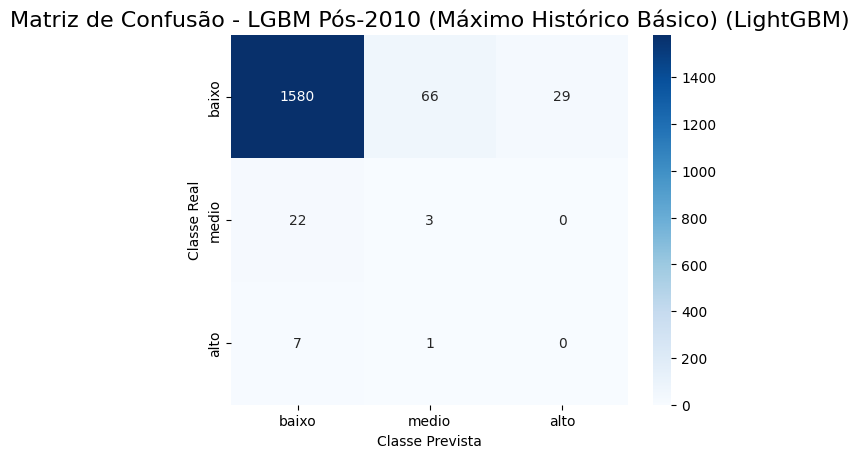


--- Análise de Importância das Features (LightGBM) ---


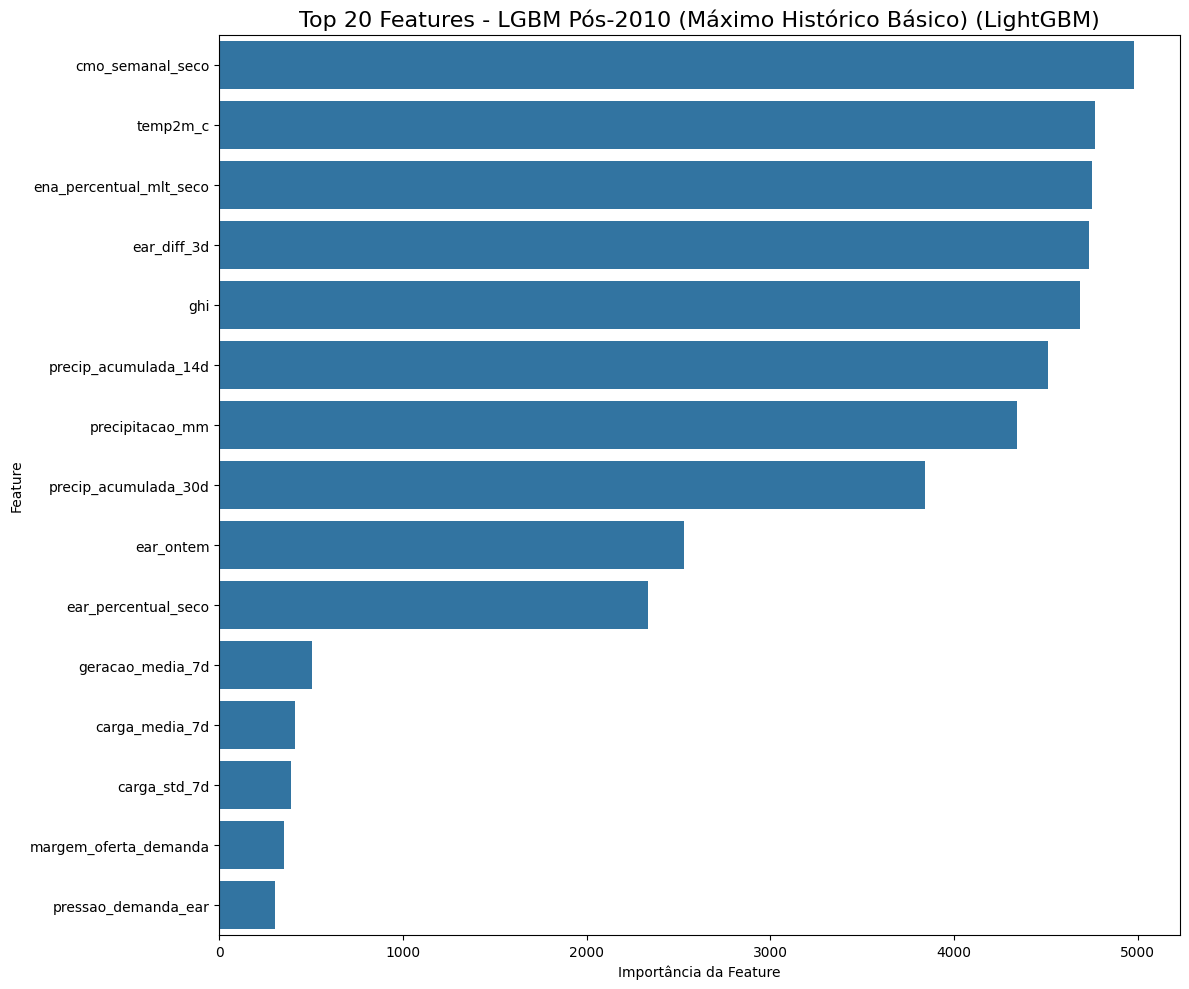

In [7]:
# --- Célula 7: Avaliação Final e Análise de Features (LightGBM) ---

# 1. Avaliação com Ajuste de Limiar
print("\nObtendo as probabilidades do melhor modelo LightGBM...")
y_pred_proba = best_model.predict_proba(X_test_scaled)

threshold_alto = 0.10
threshold_medio = 0.20

y_pred_custom = []
for probs in y_pred_proba:
    prob_baixo, prob_medio, prob_alto = probs
    if prob_alto >= threshold_alto: y_pred_custom.append(2)
    elif prob_medio >= threshold_medio: y_pred_custom.append(1)
    else: y_pred_custom.append(0)

y_pred_custom = np.array(y_pred_custom)
print(f"\n--- Resultados Finais do Cenário: {nome_cenario} (LightGBM) ---")
print(classification_report(y_test, y_pred_custom, target_names=mapeamento_risco.keys(), zero_division=0))

cm_custom = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', xticklabels=mapeamento_risco.keys(), yticklabels=mapeamento_risco.keys())
plt.title(f'Matriz de Confusão - {nome_cenario} (LightGBM)', fontsize=16)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

# 2. Análise de Importância das Features
print("\n--- Análise de Importância das Features (LightGBM) ---")
feature_names = X.columns
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title(f'Top 20 Features - {nome_cenario} (LightGBM)', fontsize=16)
plt.xlabel('Importância da Feature')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()